In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (classification_report, roc_auc_score,
                             precision_recall_curve, PrecisionRecallDisplay)

In [28]:
# Configuración global
DATA_PATH = '../data/EarlyRetirementPrediction.xlsx'
SAVE_PATH = '../data/EarlyRetirementModelPredictions.csv'
FEATURES_PATH = '../data/EarlyRetirementFeatures.csv'
COMPARISON_PATH = '../data/HighRiskCustomerComparison.csv'

RANDOM_STATE = 42
TEST_SIZE_RATIO = 0.2
HIGH_RISK_THRESHOLD = 0.8
N_JOBS = -1  # Usar todos los núcleos disponibles
CV_SPLITS = 5

In [ ]:
# 1. Carga y preparación de datos
def load_data(file_path):
    """Carga y prepara el conjunto de datos"""
    data = pd.read_excel(file_path)
    
    # Manejar valores faltantes
    if data.drop(columns=['Retire Before 65 Years Old']).isnull().any().any():
        data = data.fillna(data.mean())
    
    return data

# Carga y preparación de datos
retirement_data = load_data(DATA_PATH)
features = retirement_data.drop(columns=['Retire Before 65 Years Old', 'Probabilidades de Retiro Temprano'])
target = retirement_data['Retire Before 65 Years Old']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    features, target, 
    test_size=TEST_SIZE, 
    stratify=target,
    random_state=RANDOM_STATE
)

In [4]:
# 2. Preprocesamiento y modelado
def create_pipeline():
    """Crea el pipeline de procesamiento y modelo"""
    base_models = [
        ('logistic_regression', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        # ('xgb', XGBClassifier(random_state=42, scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(), eval_metric='logloss')),
        # ('rf', RandomForestClassifier(random_state=42)),
        # ('mlp', MLPClassifier(random_state=42, max_iter=2000))
    ]
    # selector = SelectFromModel(XGBClassifier(random_state=42), threshold='median')

    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        # ('selector', selector),
        ('pca', PCA()),
        ('stack', StackingClassifier(
            estimators=base_models,
            final_estimator=LogisticRegression(random_state=RANDOM_STATE),
            cv=5
        ))
    ])

def get_hyperparameter_grid():
    """Define la cuadrícula de hiperparámetros para la optimización"""
    return {
        'pca__n_components': [5, 10, None],
        'stack__logistic_regression__C': [0.01, 0.1, 1, 10],
        'stack__logistic_regression__solver': ['liblinear', 'saga'],
        'stack__logistic_regression__penalty': ['l1', 'l2'],
        'stack__logistic_regression__class_weight': ['balanced', None],
        # 'stack__xgb__learning_rate': [0.01, 0.05, 0.1],
        # 'stack__xgb__max_depth': [3, 4, 5],
        # 'stack__rf__n_estimators': [100, 200],
        # 'stack__mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        # 'stack__mlp__alpha': [0.0001, 0.001, 0.01],
        # 'stack__mlp__learning_rate_init': [0.001, 0.01, 0.1]
    }

In [7]:
# Configuración del modelo
pipeline = create_pipeline()
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=get_hyperparameter_grid(),
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=N_JOBS,
    verbose=1
)

# Entrenamiento del modelo
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('pca', PCA()),
                                       ('stack',
                                        StackingClassifier(cv=5,
                                                           estimators=[('logistic_regression',
                                                                        LogisticRegression(max_iter=1000,
                                                                                           random_state=42))],
                                                           final_estimator=LogisticRegression(random_state=42)))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [5, 10, None],
                         'stack__logistic_regression__C': [0.01, 0.1, 1, 10],
                         'stack__logistic_regression__class_weight': ['balanced',
                                                                      None],
                         'stack__logistic_regression__penalty': ['l1', 'l2'],
                         'stack__logistic_regression__solver': ['liblinear',
                                                                'saga']},
             scoring='roc_auc', verbose=1)

In [8]:
# 3. Evaluación y optimización
def optimize_threshold(y_true, y_proba):
    """Encuentra el mejor threshold para clasificación basado en F1-score"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calcular F1-score evitando divisiones por cero
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    best_idx = f1_scores.argmax()
    
    return thresholds[best_idx], {
        'threshold': thresholds[best_idx],
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'f1': f1_scores[best_idx]
    }

# Evaluación del modelo
best_model = grid_search.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# Optimización de threshold
best_threshold, metrics = optimize_threshold(y_test, y_proba)
y_pred_optimized = (y_proba >= best_threshold).astype(int)

# Resultados
print(f"\nMejores parámetros: {grid_search.best_params_}")
print("\nReporte de clasificación con threshold optimizado:")
print(classification_report(y_test, y_pred_optimized))
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


Mejores parámetros: {'pca__n_components': 10, 'stack__logistic_regression__C': 1, 'stack__logistic_regression__class_weight': 'balanced', 'stack__logistic_regression__penalty': 'l2', 'stack__logistic_regression__solver': 'liblinear'}

Reporte de clasificación con threshold optimizado:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       159
           1       0.81      0.83      0.82       141

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300

AUC-ROC: 0.8612


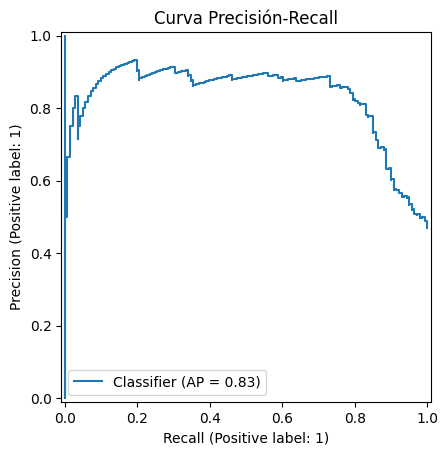

In [9]:
# Visualización
PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.title('Curva Precisión-Recall')
plt.show()

In [23]:
# Guardar resultados
retirement_data['ID_Cliente'] = retirement_data.index
retirement_data['Predicción Modelo'] = best_model.predict(features)
retirement_data['Probabilidad Modelo'] = best_model.predict_proba(features)[:, 1]
retirement_data.to_csv(SAVE_PATH, index=False)

In [24]:
# Contar los 1s y 0s en la predicción y calcular su porcentaje
count_1s = retirement_data['Predicción Modelo'].sum()
count_0s = (retirement_data['Predicción Modelo'] == 0).sum()
total = len(retirement_data)

# Calcular los porcentajes
percentage_1s = (count_1s / total) * 100
percentage_0s = (count_0s / total) * 100

(count_1s, count_0s, percentage_1s, percentage_0s)

(np.int64(711), np.int64(789), np.float64(47.4), np.float64(52.6))

In [ ]:
# Crear una versión del pipeline sin la etapa PCA
scaler = StandardScaler()
pipeline_no_pca = ImbPipeline([
    ('scaler', scaler),
    ('smote', SMOTE(random_state=42)),
    # Omitir PCA para mantener las variables originales
    ('model', RandomForestClassifier(random_state=42))
])

# Entrenar el modelo
pipeline_no_pca.fit(X_train, y_train)

# Extraer la importancia de variables
model_no_pca = pipeline_no_pca.named_steps['model']
importances = model_no_pca.feature_importances_
feature_names = features.columns

# Crear un DataFrame con la importancia de las características
feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Mostrar la importancia de las variables
print("Importancia de las variables (modelo RandomForest sin PCA):")
print(feat_importance_df)

# Exportar el DataFrame a un archivo CSV
feat_importance_df.to_csv(FEATURES_PATH, index=False)
print(f"\nLa importancia de las características se ha exportado a '{FEATURES_PATH}'.")

Importancia de las variables (modelo RandomForest sin PCA):
                    feature  importance
6                Dependants    0.398137
9              Credit Score    0.123921
4            Monthly Income    0.102932
7         Unemployment Rate    0.079359
10  Government Bonds Return    0.076904
8              Stock Market    0.076678
2           Education Level    0.044638
0                    Gender    0.031557
1                   Desease    0.025282
3            Marital Status    0.021929
5         Employee/Employer    0.018664

La importancia de las características se ha exportado a '..\data\EarlyRetirementFeatures.csv'.


In [26]:
import pandas as pd

# 1. Filtrar clientes de alto riesgo (ej: probabilidad > 0.8)
high_risk_customers = retirement_data[retirement_data['Probabilidad Modelo'] > 0.8]

# 2. Seleccionar el cliente con la mayor probabilidad de retiro temprano
most_risky_customer = high_risk_customers.loc[high_risk_customers['Probabilidad Modelo'].idxmax()]

# 3. Calcular el promedio de características del grupo de alto riesgo
high_risk_avg = high_risk_customers.mean()

# 4. Calcular el promedio global de todas las características
global_avg = retirement_data.mean()

# 5. Crear un DataFrame para la tabla comparativa
comparison_table = pd.DataFrame({
    'Feature': most_risky_customer.index,  # Nombres de las características
    'Cliente Seleccionado': most_risky_customer.values,  # Valores del cliente seleccionado
    'Promedio Grupo de Alto Riesgo': high_risk_avg.values,  # Valores promedio del grupo de alto riesgo
    'Promedio Global': global_avg.values  # Valores promedio global
})

# 6. Filtrar solo las características relevantes (excluir columnas no numéricas como ID o Probabilidad)
comparison_table = comparison_table[~comparison_table['Feature'].isin(['ID_Cliente', 'Probabilidad Modelo'])]

# 7. Mostrar la tabla
print(comparison_table)

# 8. Guardar la tabla en un archivo CSV (opcional)
comparison_table.to_csv("..\\data\\comparacion_cliente_riesgoso_con_promedio_global.csv", index=False)

                              Feature  Cliente Seleccionado  \
0          Retire Before 65 Years Old              1.000000   
1                              Gender              1.000000   
2                             Desease              1.000000   
3                     Education Level              1.000000   
4                      Marital Status              0.000000   
5                      Monthly Income          15000.000000   
6                   Employee/Employer              1.000000   
7                          Dependants              4.000000   
8                   Unemployment Rate              2.939656   
9                        Stock Market          19520.666670   
10                       Credit Score            693.000000   
11            Government Bonds Return              8.896667   
12  Probabilidades de Retiro Temprano                   NaN   
13                  Predicción Modelo              1.000000   

    Promedio Grupo de Alto Riesgo  Promedio Global  
0